In [2]:
# #importing libraries
# from fastai import *
# from fastai.vision import *
# from fastai.metrics import error_rate
# import os
# import pandas as pd
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from sklearn.utils import shuffle
# import tensorflow as tf
# from PIL import Image, ImageEnhance

# from tensorflow.keras.preprocessing.image import load_img
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
# from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
def displayImage(path,name):
    exists=os.path.exists(path)
    if exists:
        image = cv2.imread(path)
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 2, 1)
        plt.title(name)
        plt.imshow(image)
    else:
        print("Image does not exist check path again ",path)


In [4]:
train_dir = '/kaggle/input/kermany2018/OCT2017 /train/'
test_dir = '/kaggle/input/kermany2018/OCT2017 /test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

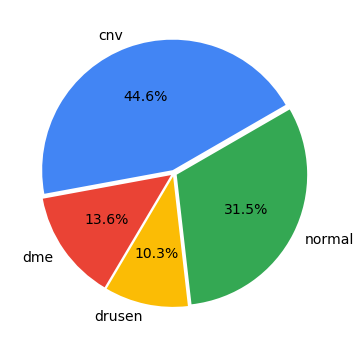

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='CNV']),
         len([x for x in train_labels if x=='DME']),
         len([x for x in train_labels if x=='DRUSEN']),
         len([x for x in train_labels if x=='NORMAL'])],
        labels=['cnv','dme', 'drusen', 'normal'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [6]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


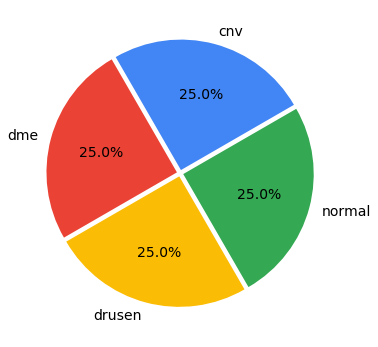

In [7]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in test_labels if x=='CNV']),
         len([x for x in test_labels if x=='DME']),
         len([x for x in test_labels if x=='DRUSEN']),
         len([x for x in test_labels if x=='NORMAL'])],
        labels=['cnv','dme', 'drusen', 'normal'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

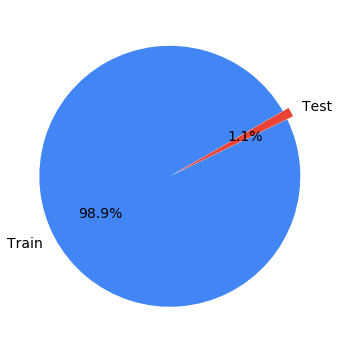

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [9]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

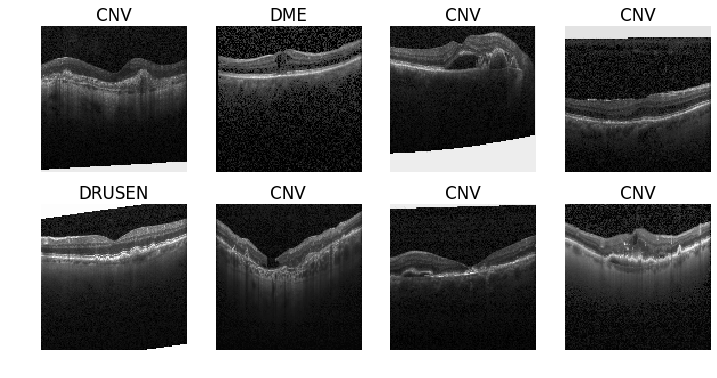

In [10]:
IMAGE_SIZE=128
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})

In [11]:
#Preprocessor for Images
# def processImage(path,showImg="FALSE",kernel4MBlur=5):
#     exists=os.path.exists(path)
#     if exists:
#         image = cv2.imread(path)
#         if showImg=="TRUE":
#             fig = plt.figure()
#             ax = fig.add_subplot(1, 2, 1)
#             imgplot = plt.imshow(image)
#             ax.set_title('Before')
        
#         #do changes to image now
#         image=cv2.blur(image,(kernel4MBlur,kernel4MBlur))  #Median Blur of default size 5
        
        
        
#         if showImg=="TRUE":
#             ax = fig.add_subplot(1, 2, 2)
#             imgplot = plt.imshow(image)
#             ax.set_title('After')

#         #save the image now
#         cv2.imwrite(path,image)

# processImage("/kaggle/input/kermany2018/oct2017/OCT2017 /val/NORMAL/NORMAL-5246808-2.jpeg",showImg="TRUE",kernel4MBlur=9)

In [12]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels            

In [13]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [15]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Train for 4174 steps
Epoch 1/4
4174/4174 [==============================] - 1197s 287ms/step - loss: 0.3325 - sparse_categorical_accuracy: 0.8859
Epoch 2/4
4174/4174 [==============================] - 465s 111ms/step - loss: 0.2211 - sparse_categorical_accuracy: 0.9254
Epoch 3/4
4174/4174 [==============================] - 415s 99ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.9506


In [16]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

31it [00:14,  2.18it/s]                        


In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         CNV       0.95      0.98      0.97       242
         DME       0.98      0.99      0.99       242
      DRUSEN       1.00      0.93      0.96       242
      NORMAL       0.98      1.00      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968

